## Cluster Differentially Methylated Genes

In [1]:
import pandas as pd
from ALLCools.clustering import one_vs_rest_dmg

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Load

In [3]:
cell_meta = pd.read_csv('../results/ClusteringResults.csv.gz', index_col=0)
mcds_path = '../results/geneslop2k_HCGN_frac.mcds'
cluster_col = 'leiden'
mc_type = 'HCGN'

### Calculate DMG

In [4]:
if __name__ == '__main__':
    dmg_table = one_vs_rest_dmg(cell_meta,
                                group=cluster_col,
                                mcds_paths=mcds_path,
                                obs_dim='cell',
                                var_dim='geneslop2k',
                                mc_type='mc_type',
                                top_n=10,
                                adj_p_cutoff=0.001,
                                fc_cutoff=0.8,
                                auroc_cutoff=0.8,
                                max_cluster_cells=100,
                                max_other_fold=5,
                                cpu=10)
    print(dmg_table)

Calculating cluster 0 DMGs.
Calculating cluster 1 DMGs.Calculating cluster 2 DMGs.

Calculating cluster 3 DMGs.
Calculating cluster 4 DMGs.Calculating cluster 5 DMGs.

Calculating cluster 6 DMGs.
Calculating cluster 7 DMGs.
7 Finished.
5 Finished.
6 Finished.
2 Finished.
1 Finished.
3 Finished.
0 Finished.
4 Finished.
                       pvals_adj        fc    AUROC  cluster
names                                                       
ENSG00000179399.15  1.369399e-25  0.772966  0.86118        5
ENSG00000149972.12  1.338372e-23  0.784235  0.84636        5
ENSG00000251574.8   3.332131e-23  0.781265  0.84256        5
ENSG00000157445.15  1.426568e-21  0.788988  0.82854        5
ENSG00000165973.19  4.913269e-21  0.776712  0.82438        5
ENSG00000172260.15  4.913269e-21  0.771589  0.82410        5
ENSG00000155657.29  1.947945e-44  0.510653  0.96571        4
ENSG00000115641.19  1.397897e-41  0.262225  0.94988        4
ENSG00000183023.19  3.616774e-40  0.618623  0.94170        4
ENSG00000

### Save

In [5]:
dmg_table.to_hdf(f'../results/{cluster_col}.OneVsRestDMG.{mc_type}.hdf', key='data')
dmg_table.to_csv(f'../results/{cluster_col}.OneVsRestDMG.{mc_type}.csv')

## Plot Cluster DMGs

In [6]:
import pandas as pd
import anndata
import matplotlib.pyplot as plt

from ALLCools.plot import *
from ALLCools.mcds import MCDS

### Parameters

In [7]:
adata_path = '../results/chrom100k-clustering.h5ad'
cluster_col = 'leiden'

downsample = 30000

mc_type = 'HCGN'
coord_base = 'umap'

cluster_dmg_path = '../results/leiden.OneVsRestDMG.hdf'

### Load clustering results

In [8]:
adata = anndata.read_h5ad(adata_path)

# downsample cells when plot - to use less memory
if downsample and (adata.n_obs > downsample):
    use_cells = adata.obs.sample(downsample, random_state=0).index
    adata = adata[adata.obs_names.isin(use_cells), :].copy()
else:
    use_cells = adata.obs_names

### Cluster DMGs

In [9]:
cluster_dmgs = pd.read_hdf(cluster_dmg_path)
cluster_dmgs['cluster'] = cluster_dmgs['cluster'].astype(str)
cluster_dmgs.head()

pvals_adj        fc    AUROC cluster
names                                                      
ENSG00000179399.15  1.369399e-25  0.772966  0.86118       5
ENSG00000149972.12  1.338372e-23  0.784235  0.84636       5
ENSG00000251574.8   3.332131e-23  0.781265  0.84256       5
ENSG00000157445.15  1.426568e-21  0.788988  0.82854       5
ENSG00000165973.19  4.913269e-21  0.776712  0.82438       5

### Gene mC Fraction Data

In [10]:
gene_meta = pd.read_csv(f'../results/GeneMetadata_HCGN.csv.gz', index_col=0)
gene_name_to_gene_id = {v: k for k, v in gene_meta['gene_name'].items()}
gene_meta.index.name = 'gene_id'

gene_frac_da = MCDS.open(mcds_path, use_obs=use_cells)[f'geneslop2k_da_frac']
gene_frac_da = gene_frac_da.load() #sel(mc_type = mc_type) if more than one mc_type

### Plot

In [11]:
def get_gene_values_by_name(gene_name):
    data = gene_frac_da.sel(geneslop2k=gene_name_to_gene_id[gene_name]).to_pandas()
    data.name = gene_name
    return data

#### Plot Single Gene

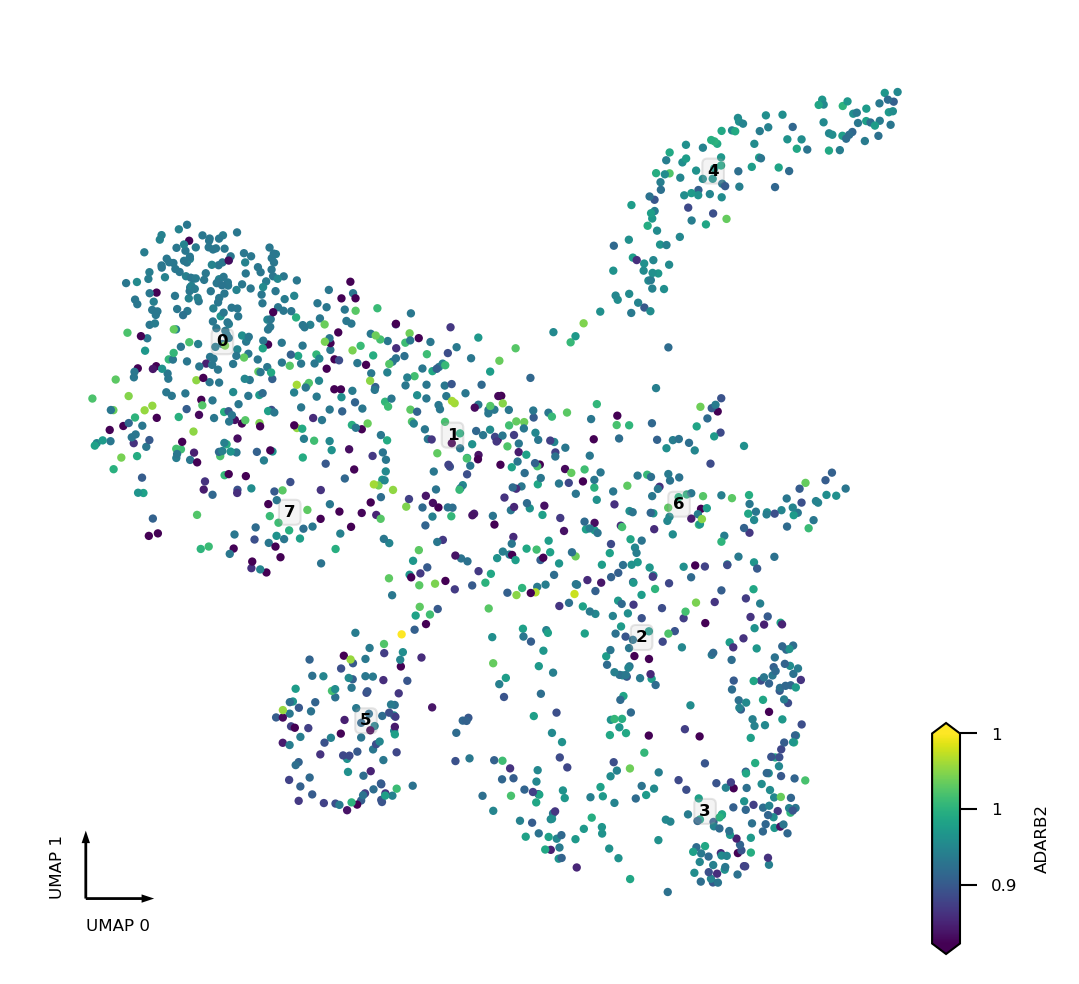

In [12]:
gene = 'ADARB2'
hue_norm = (0.67, 1.5)
coord_base = 'umap'

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

_ = continuous_scatter(ax=ax,
                       data=adata,
                       hue=get_gene_values_by_name(gene),
                       hue_norm=hue_norm,
                       text_anno=cluster_col,
                       coord_base=coord_base,
                       max_points=None,
                       s=4)

#### Plot Cluster Top Markers

In [13]:
def plot_cluster_and_genes(cluster, cell_meta, cluster_col, genes_data,
                           coord_base='umap', ncols=5, axes_size=3, dpi=150, hue_norm=(0.67, 1.5)):
    ncols = max(2, ncols)
    nrows = 1 + (genes_data.shape[1] - 1) // ncols + 1

    # figure
    fig = plt.figure(figsize=(ncols * axes_size, nrows * axes_size), dpi=dpi)
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

    # cluster axes
    ax = fig.add_subplot(gs[0, 0])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        axis_format=None,
                        hue=cluster_col,
                        palette='tab20')
    ax.set_title('All Clusters')
    ax = fig.add_subplot(gs[0, 1])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        hue=cell_meta.obs[cluster_col] == cluster,  ## debug by Qiaoshan
                        axis_format=None,
                        palette={
                            True: 'red',
                            False: 'lightgray'
                        })
    ax.set_title('This Cluster')

    # gene axes
    for i, (gene, data) in enumerate(genes_data.iteritems()):
        col = i % ncols
        row = i // ncols + 1
        ax = fig.add_subplot(gs[row, col])

        if ax.get_subplotspec().is_first_col() and ax.get_subplotspec().is_last_row():
            axis = 'tiny'
        else:
            axis = None

        continuous_scatter(ax=ax,
                           data=cell_meta,
                           hue=data,
                           axis_format=axis,
                           hue_norm=hue_norm,
                           coord_base=coord_base)
        ax.set_title(f'{data.name}')
    fig.suptitle(f'Cluster {cluster} Top Markers')
    return fig

#### Per Cluster Plots

In [14]:
cluster_dmgs.head()

pvals_adj        fc    AUROC cluster
names                                                      
ENSG00000179399.15  1.369399e-25  0.772966  0.86118       5
ENSG00000149972.12  1.338372e-23  0.784235  0.84636       5
ENSG00000251574.8   3.332131e-23  0.781265  0.84256       5
ENSG00000157445.15  1.426568e-21  0.788988  0.82854       5
ENSG00000165973.19  4.913269e-21  0.776712  0.82438       5

In [15]:
cluster = '4'
genes = cluster_dmgs[cluster_dmgs['cluster'] == cluster].sort_values('AUROC', ascending=False)[:10]
genes_data = gene_frac_da.sel(geneslop2k=genes.index).to_pandas()
genes_data.columns = genes_data.columns.map(gene_meta['gene_name'])
genes_data

geneslop2k                                               TTN      FHL2  \
cell                                                                     
SP-HE-scNOME-MW210318-08-H08_S64_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-10-A10_S73_demulti_barcod...  1.028804  1.000000   
SP-HE-scNOME-MW210318-11-A11_S81_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-01-G01_S7_demulti_barcode_15  1.018077  1.000000   
SP-HE-scNOME-MW210318-12-B12_S90_demulti_barcod...  1.239147  1.000000   
...                                                      ...       ...   
SP-HE-scNOME-MW210318-11-E11_S85_demulti_barcod...  0.534628  0.224306   
SP-HE-scNOME-MW210318-05-E05_S37_demulti_barcod...  1.392851  1.325159   
SP-HE-scNOME-MW210318-07-C07_S51_demulti_barcod...  0.487770  0.019226   
SP-HE-scNOME-MW210318-07-A07_S49_demulti_barcod...  1.271348  0.961537   
SP-HE-scNOME-MW210318-03-B03_S18_demulti_barcod...  0.998917  1.006315   

geneslop2k                                            SLC8A1    PDLIM5  \
cell                                                                     
SP-HE-scNOME-MW210318-08-H08_S64_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-10-A10_S73_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-11-A11_S81_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-01-G01_S7_demulti_barcode_15  1.000000  1.000000   
SP-HE-scNOME-MW210318-12-B12_S90_demulti_barcod...  1.239147  0.200945   
...                                                      ...       ...   
SP-HE-scNOME-MW210318-11-E11_S85_demulti_barcod...  0.607505  0.460026   
SP-HE-scNOME-MW210318-05-E05_S37_demulti_barcod...  1.149508  1.232994   
SP-HE-scNOME-MW210318-07-C07_S51_demulti_barcod...  0.665853  0.530788   
SP-HE-scNOME-MW210318-07-A07_S49_demulti_barcod...  1.119645  1.307619   
SP-HE-scNOME-MW210318-03-B03_S18_demulti_barcod...  1.007818  1.001224   

geneslop2k                                              MYH7    SORBS2  \
cell                                                                     
SP-HE-scNOME-MW210318-08-H08_S64_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-10-A10_S73_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-11-A11_S81_demulti_barcod...  1.000000  1.028183   
SP-HE-scNOME-MW210318-01-G01_S7_demulti_barcode_15  1.000000  1.000000   
SP-HE-scNOME-MW210318-12-B12_S90_demulti_barcod...  1.000000  1.265858   
...                                                      ...       ...   
SP-HE-scNOME-MW210318-11-E11_S85_demulti_barcod...  0.132562  0.607655   
SP-HE-scNOME-MW210318-05-E05_S37_demulti_barcod...  0.837150  1.188836   
SP-HE-scNOME-MW210318-07-C07_S51_demulti_barcod...  0.119143  0.518117   
SP-HE-scNOME-MW210318-07-A07_S49_demulti_barcod...  1.390138  1.227768   
SP-HE-scNOME-MW210318-03-B03_S18_demulti_barcod...  1.015959  1.003286   

geneslop2k                                             RBM20       QKI  \
cell                                                                     
SP-HE-scNOME-MW210318-08-H08_S64_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-10-A10_S73_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-11-A11_S81_demulti_barcod...  1.000000  1.000000   
SP-HE-scNOME-MW210318-01-G01_S7_demulti_barcode_15  1.000000  1.000000   
SP-HE-scNOME-MW210318-12-B12_S90_demulti_barcod...  1.265858  1.000000   
...                                                      ...       ...   
SP-HE-scNOME-MW210318-11-E11_S85_demulti_barcod...  0.355954  0.355954   
SP-HE-scNOME-MW210318-05-E05_S37_demulti_barcod...  1.248993  1.164140   
SP-HE-scNOME-MW210318-07-C07_S51_demulti_barcod...  0.413550  0.311358   
SP-HE-scNOME-MW210318-07-A07_S49_demulti_barcod...  1.176140  0.903595   
SP-HE-scNOME-MW210318-03-B03_S18_demulti_barcod...  0.998450  1.007008   

geneslop2k                                          ENSG00000289258     GCOM1  
cell                                                                

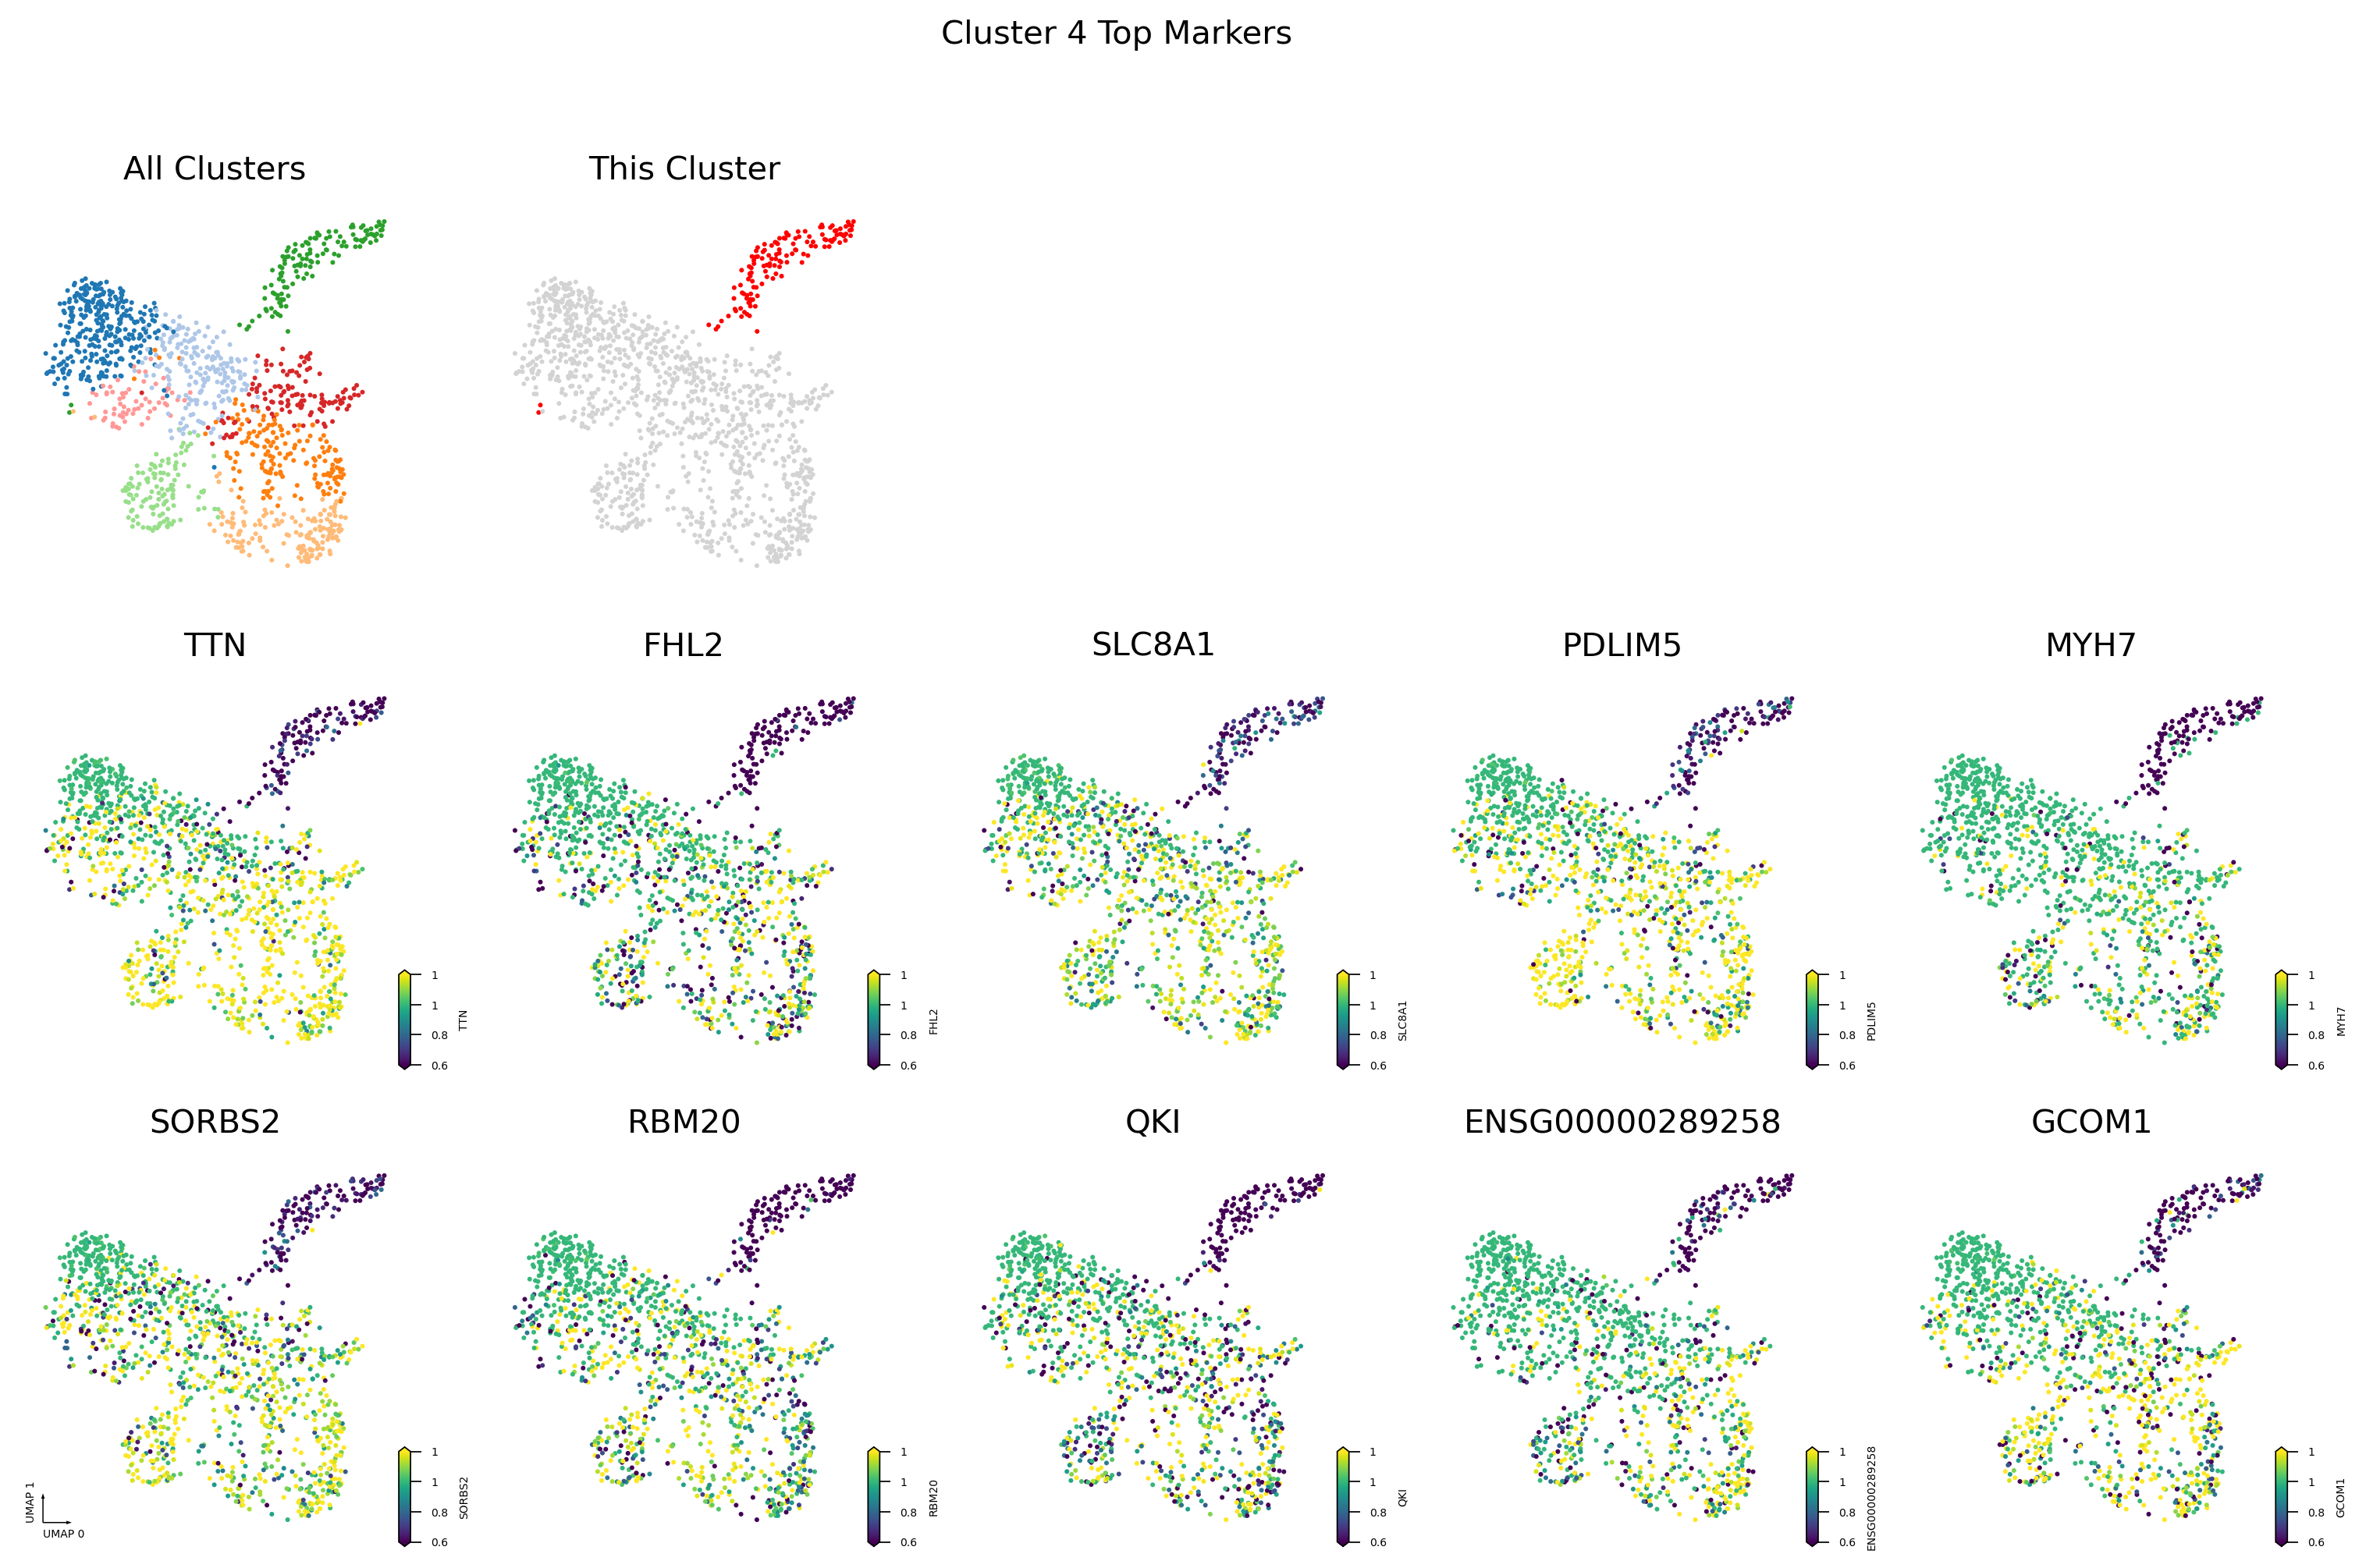

In [16]:
fig = plot_cluster_and_genes(cluster=cluster,
                             cell_meta=adata,
                             cluster_col=cluster_col,
                             genes_data=genes_data,
                             coord_base='umap',
                             ncols=5,
                             axes_size=3,
                             dpi=250,
                             hue_norm=(0.6, 1.2))

fig.savefig(f'../results/{cluster}.TopMarker.png', bbox_inches='tight')